## Homework (for 2 weeks)

Train a Vision Transformer model on any of MedMNIST datasets (except NoduleMNIST), followed by prediction and explanation.

Essentially apply the above steps with a different ViT model trained on one of the MedMNIST datasets.

In [7]:
import sys
import os
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
import gdown
import os
import matplotlib.pyplot as plt
from medmnist import INFO, OrganMNIST3D

sys.path.append("./obz")

In [10]:
def take_middle_slice(inpt: np.ndarray):
    inpt = inpt.squeeze()
    X, Y, Z = inpt.shape
    slice_ = inpt[:, :, Z // 2]
    slice_ = torch.Tensor(slice_).unsqueeze(0).repeat(3, 1, 1)
    return slice_
    
TRANSFORMS = v2.Compose([v2.Lambda(take_middle_slice),
                         v2.Resize(size=(224,224))
                         ])

NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_dir = "./organ_data"
os.makedirs(data_dir, exist_ok=True)

ref_set = OrganMNIST3D(root=data_dir, split="val", size=64, transform=TRANSFORMS, download=True)
inf_set = OrganMNIST3D(root=data_dir, split="test", size=64, transform=TRANSFORMS)

ref_loader = DataLoader(ref_set, batch_size=32, shuffle=False)
inf_loader = DataLoader(inf_set, batch_size=6, shuffle=True)

train_set = OrganMNIST3D(root=data_dir, split="train", size=64, transform=TRANSFORMS, download=True)
train_loader = DataLoader(train_set, batch_size=32, shuffle=False)

CLASS_NAMES = list(INFO['organmnist3d']['label'].values())
LOGIT2NAME = INFO['organmnist3d']['label']

In [20]:
LOGIT2NAME

{'0': 'liver',
 '1': 'kidney-right',
 '2': 'kidney-left',
 '3': 'femur-right',
 '4': 'femur-left',
 '5': 'bladder',
 '6': 'heart',
 '7': 'lung-right',
 '8': 'lung-left',
 '9': 'spleen',
 '10': 'pancreas'}

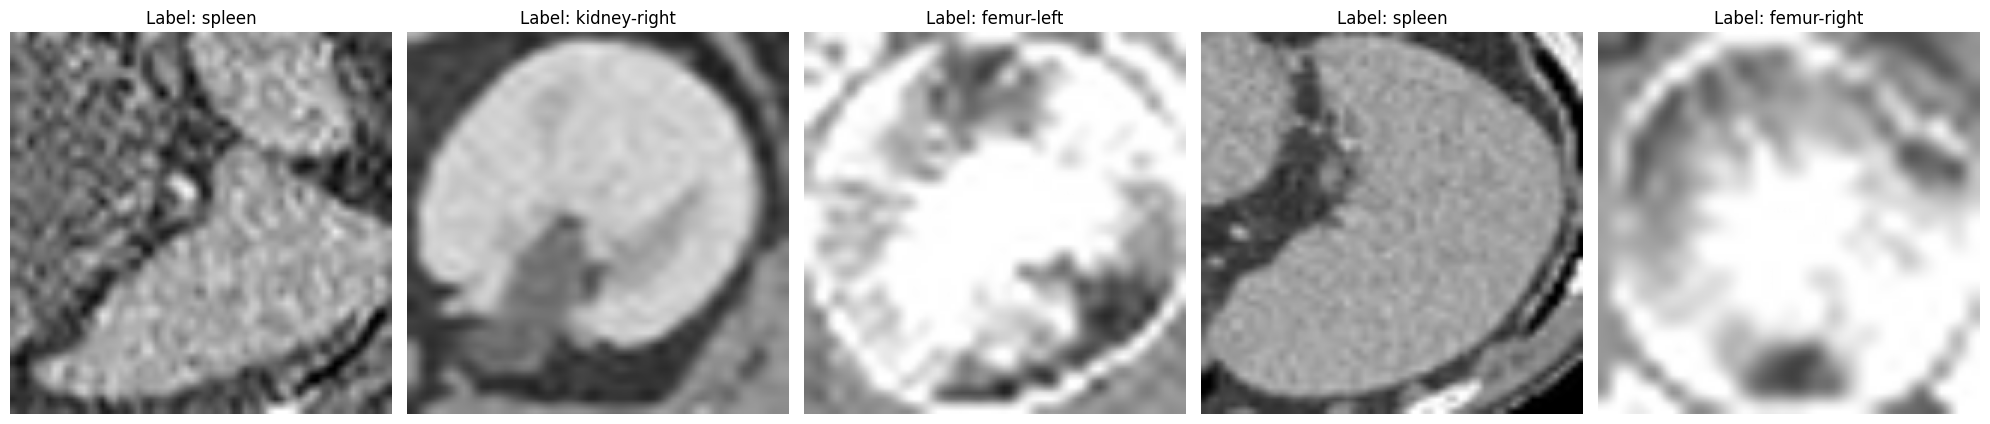

In [11]:
samples, labels = next(iter(ref_loader))

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image = samples[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {CLASS_NAMES[labels[i].item()]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
from transformers import ViTConfig, ViTForImageClassification

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = len(CLASS_NAMES)

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    config=config
)
model = model.to(DEVICE)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    total_loss = 0
    for batch in tqdm(loader):
        imgs = batch[0].to(DEVICE)
        labels = batch[1].squeeze().long().to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [15]:
for epoch in range(3):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1} loss: {loss:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [13:40<00:00, 26.45s/it]


Epoch 1 loss: 1.6297


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [12:25<00:00, 24.05s/it]


Epoch 2 loss: 0.7265


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [12:22<00:00, 23.96s/it]

Epoch 3 loss: 0.4146


In [16]:
from sklearn.metrics import classification_report

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(DEVICE)
            labels = batch[1].squeeze().long().to(DEVICE)
            outputs = model(imgs).logits
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate(model, inf_loader)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

       liver       1.00      1.00      1.00        69
kidney-right       0.78      0.93      0.85        68
 kidney-left       0.78      0.87      0.82        69
 femur-right       0.89      0.97      0.93        65
  femur-left       0.97      0.89      0.93        65
     bladder       1.00      0.77      0.87        66
       heart       1.00      0.89      0.94        28
  lung-right       1.00      1.00      1.00        21
   lung-left       0.91      1.00      0.95        21
      spleen       0.95      0.91      0.93        69
    pancreas       1.00      0.96      0.98        69

    accuracy                           0.92       610
   macro avg       0.93      0.93      0.93       610
weighted avg       0.93      0.92      0.92       610



In [22]:
# Move samples to the appropriate device
samples = samples[:5].to(DEVICE)
labels = labels[:5].to(DEVICE)
print(labels)
print(samples.shape)

# Dont normalize the LIDC data?
# Normalize the samples
#samples = NORMALIZE(samples)


# Perform inference using the model
with torch.no_grad():
    logits = model(samples).logits
    predictions = torch.softmax(logits, dim=1).argmax(dim=1).cpu().numpy()
# Map  to class names
predicted_classes = [LOGIT2NAME[str(pred)] for pred in predictions]

# Print the results
for i, pred_class in enumerate(predicted_classes):
    print(f"Prediction for Sample {i + 1}: {pred_class}")

tensor([[9],
        [1],
        [4],
        [9],
        [3]], dtype=torch.int32)
torch.Size([5, 3, 224, 224])
Prediction for Sample 1: spleen
Prediction for Sample 2: kidney-right
Prediction for Sample 3: femur-left
Prediction for Sample 4: spleen
Prediction for Sample 5: femur-right


## Extract features for outlier detection

In [23]:
# Setup OutlierDetector
from data_inspector.extractor import FirstOrderExtractor
from data_inspector.detector import GMMDetector
# Choose desired feature extractor. Chosen extractor will be used for monitoring.
first_order_extrc = FirstOrderExtractor()

# Pass choosen extractor(s) to chosen OutlierDetector. Below we utilize outlier detector based on Gaussian Mixture Models.
gmm_detector = GMMDetector(extractors=[first_order_extrc], outlier_quantile=0.01)
# Call .fit() method with passed reference dataloader. 
# Method will extract desired image features and fit outlier detection model (in that case GMM).
gmm_detector.fit(ref_loader)

## Explain the AI model

In [71]:
import importlib
import xai.xai_tool
importlib.reload(xai.xai_tool)


<module 'xai.xai_tool' from 'C:\\Users\\48601\\Desktop\\MCBS\\./obz\\xai\\xai_tool.py'>

In [72]:
# Setup XAI Tools
from xai.xai_tool import CDAM, AttentionMap

cdam_tool = CDAM(model=model, 
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_logits",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="sigmoid")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)
# In CDAM you need to specify on which layer you want to create hooks.
cdam_tool.create_hooks(layer_name="vit.encoder.layer.11.layernorm_before")

attention_tool = AttentionMap(model=model,
                              attention_layer_id=-1,# ID of an attention layer from which to extract attention weights
                              head = None             # ID of attention head to choose. If None, attention scores are averaged.
                              )

### ! IMPORTANT !
I had to modify the `AttentionMap.explain` method as follows to match models output 
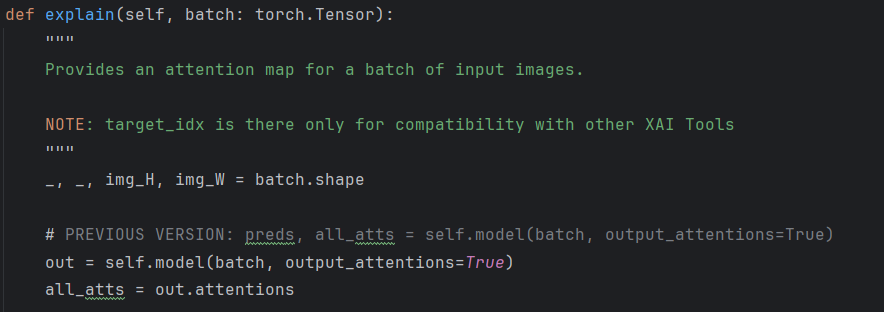

In [73]:
with torch.no_grad():
    output = model(samples, output_attentions=True)
    attentions = output.attentions

attention_tool.attentions = list(attentions)
attention_maps = attention_tool.explain(samples)

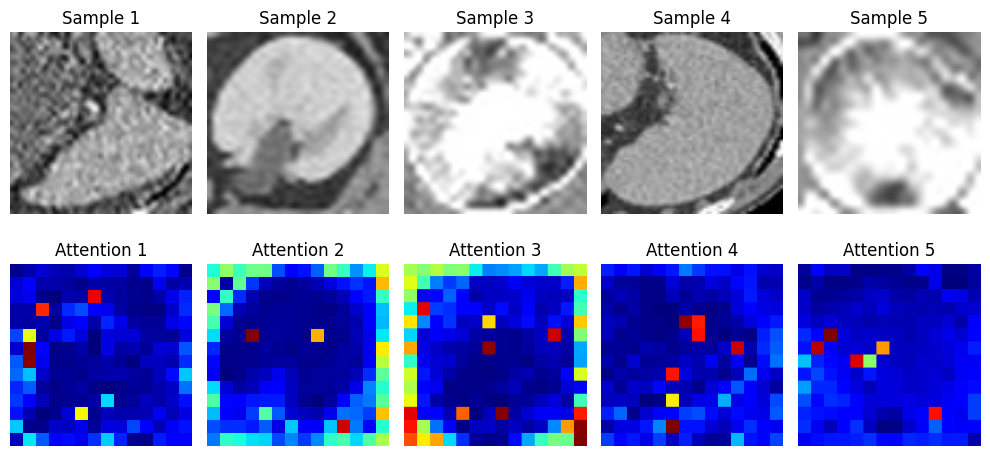

In [68]:
# Visualize samples and attention maps
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Attention maps
for i in range(5):
    attention_map = attention_maps[i].cpu().numpy()
    axes[1, i].imshow(attention_map, cmap='jet')
    axes[1, i].set_title(f"Attention {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

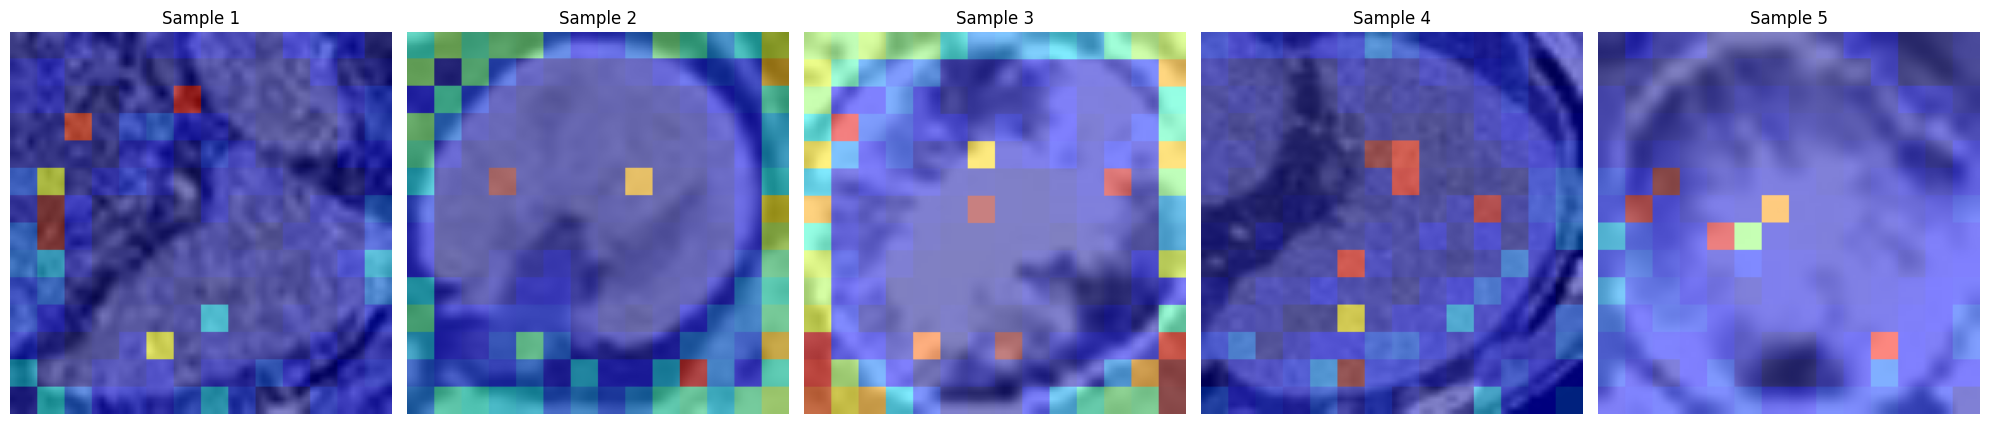

In [69]:
# Visualize attention maps overlaid on samples
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    attention_map = attention_maps[i].cpu().numpy()  # Convert attention map to numpy array

    # Overlay attention map on the original image
    axes[i].imshow(original_image, cmap='gray')
    axes[i].imshow(attention_map, cmap='jet', alpha=0.5)  # Use alpha for transparency
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### ! IMPORTANT !
I also had to modify the `CDAM._compute_cdam` method as follows to match models output 
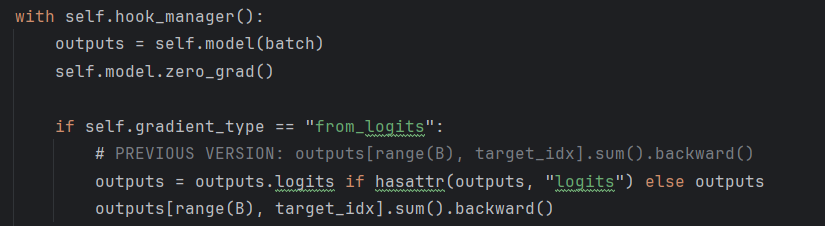

In [77]:
cdam_maps = cdam_tool.explain(samples, target_idx=[0,0,0,0,0])

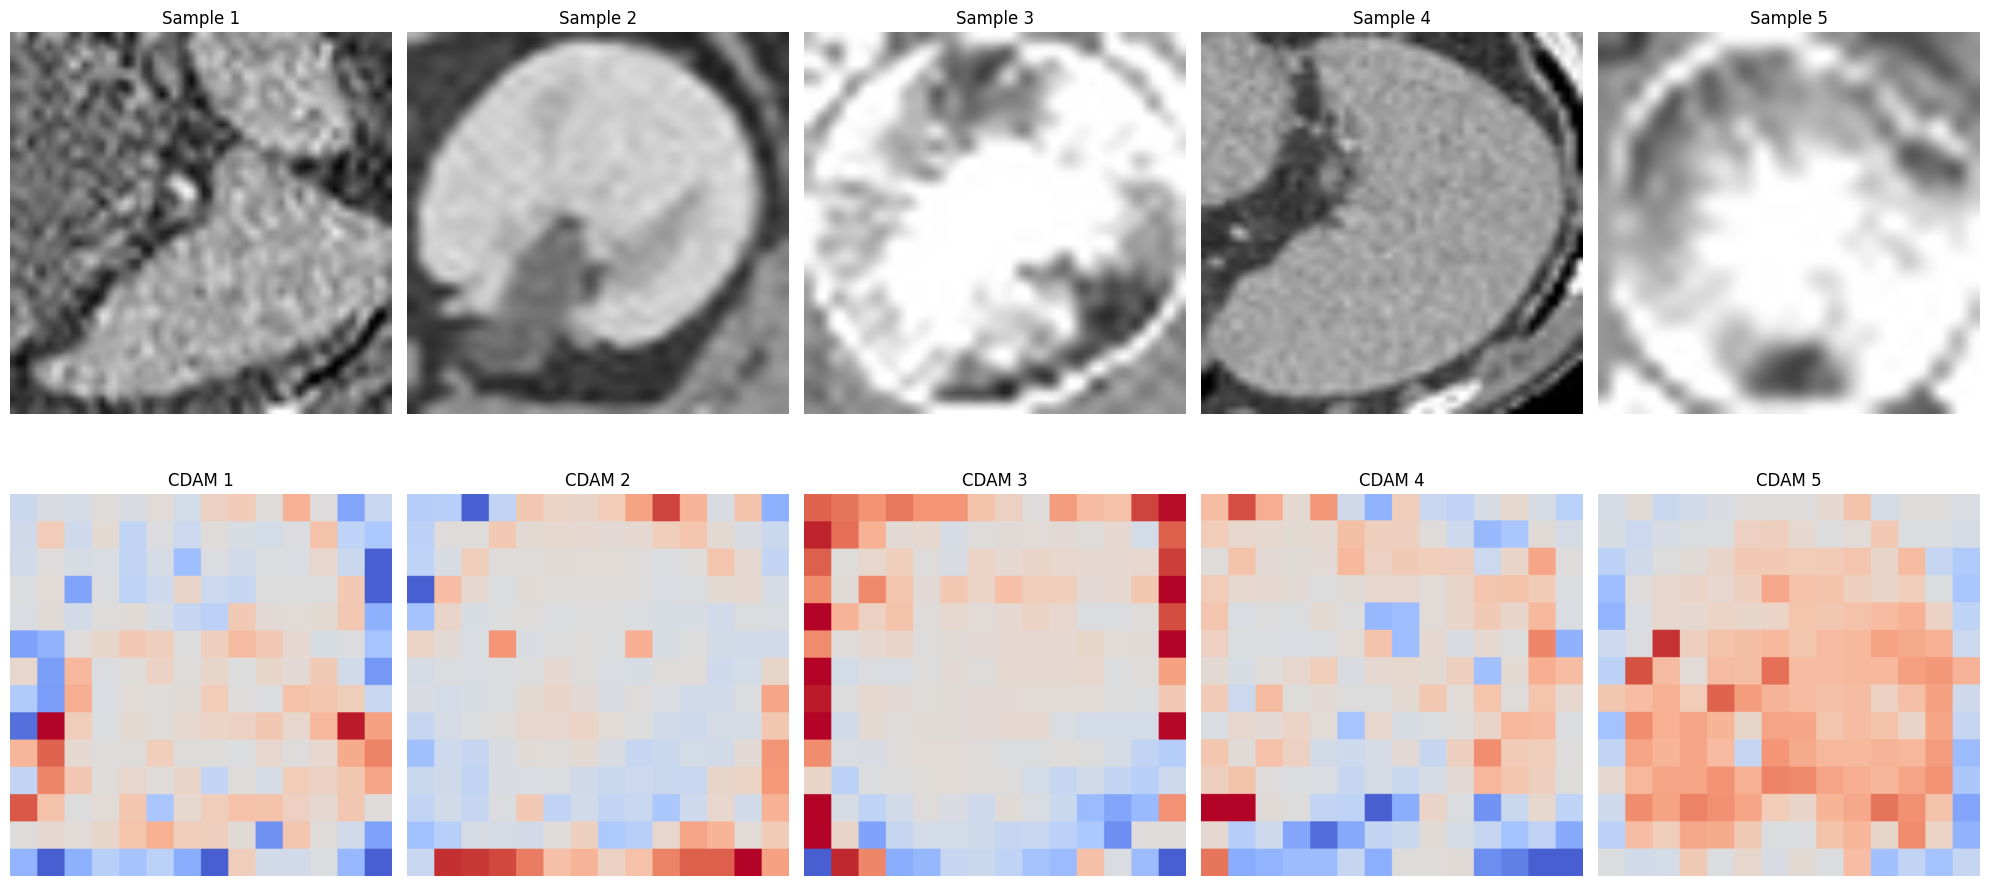

In [75]:
# Visualize samples and CDAM maps
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: CDAM maps
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].imshow(cdam_map, cmap='coolwarm', vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Diverging colormap
    axes[1, i].set_title(f"CDAM {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

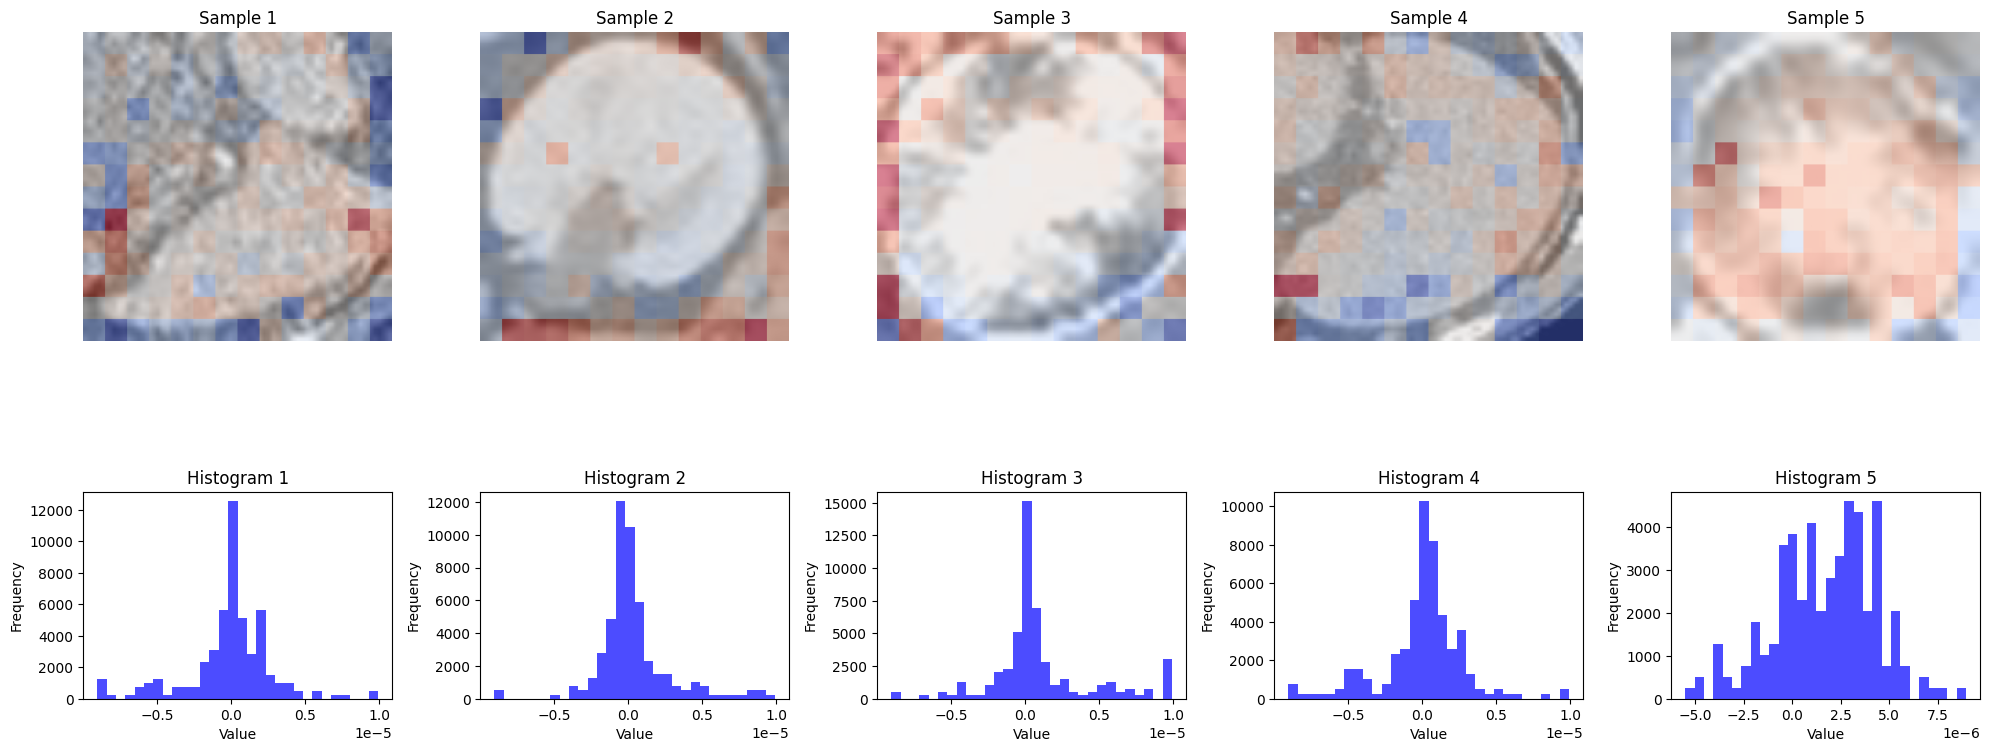

In [76]:
# Visualize CDAM maps overlaid on samples with histogram and color bar
fig, axes = plt.subplots(2, 5, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})

# First row: Original samples with overlaid CDAM maps
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array

    # Overlay CDAM map on the original image
    im = axes[0, i].imshow(original_image, cmap='gray')
    im = axes[0, i].imshow(cdam_map, cmap='coolwarm', alpha=0.5, vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Use alpha for transparency
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Histogram of CDAM map values
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].hist(cdam_map.ravel(), bins=30, color='blue', alpha=0.7)
    axes[1, i].set_title(f"Histogram {i + 1}")
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()